# NMT con attention

- Vimos una forma de implementar many to one, pero hay otra:

<img src="many2one.png">

- La LSTM no es capaz de guardar un estado para secuencias muy largas, si bien tiene mas memoria que la SimpleRNN.
_ La segunda topología mira todos los estados intermedios y elige el feature mas importante (como el max pooling de la CNN).
- Otra opción es usar una softmax (coamo alternativa a hard max).

Esta es la idea prinipal de attention: si bien uno tiene acceso a todos los features, en vez de darle la misma importancia a todos, se los pesa con algún criterio (próximo a definir).
Ese criterio está definido por una mini-red neuronal dentro de la red neuronal total. (Como la LSTM o la GRU).

Para el traductor, dejaremos de usar la primera estructura y pasaremos a la segunda:

<img src="NMT-attention.png">

El diagrama completo con attention queda:

<img src="NMT-conetxt.png">

Es importante distinguir la variable tiempo a la entrada de la variable tiempo a la salida, por eso a la variable tiempo a la entrada (que va de 1 hasta Tx) la llamaremos t'. A la variable tiempo de salida (que va de 1 hasta Ty la llamaremos t).

A cada una de las celdas LSTM del decoder le llega un vector de contexto, que es un promedio ponderado de cada uno de los estados de la LSTM. A los factores de ponderamiento los llamaremos $\alpha(t')$.  
Los $\alpha$ definirán cuanta atención se pondrá a cada estado del encoder.

Los $\alpha$ son obtenidos con la mini-nn mencionada anteriormente. Esa mini-nn estima estos parámetros en función del estado en t-1 del decoder (ya que da información de dónde estoy en la oración de salida) y de los estados del enconder (que contienen la información de la oración que estoy traduciendo).

Discusión:

How are you today? ¿Cómo estás hoy?

Como se calcula attention:

$ z_1(t,t')=concat[ s(t-1), h(t') ] $ -> $dim= \#decoStates + 2 \#encoStates$  

$ z_2(t) = [z_1(t,1)...,...z1(t,T_x) ] $ -> $dim= (T_x, \#decoStates + 2 \#encoStates)$   

$ z_3(t) = f(W_1*z_2(t)+b_1) $ -> $dim=(T_x,Attention_dim)$, $f$ podría ser una tanh o una función lineal.  

$ alphas(t,t')=softmax(W_2*z3+b_2)$ $dim=(T_x,1)$ -> **Pero esto tiene un problema, ya que la softmax de Keras realiza la operación en el eje incorrecto!. Todas las salidas valdrían 1!.**  

$ alphas(t,t')=softmaxOverTime(W_2*z3+b_2)$ -> Se implementa la softmax_over_time de forma tal que aplique la softmax en el axis=1 y no en el axis=2.  


In [57]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

In [58]:
# config
BATCH_SIZE = 256
EPOCHS = 100
LATENT_DIM = 256
LATENT_DIM_DECODER = 256 # idea: make it different to ensure things all fit together properly!
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
START_SAMPLE=100000

In [59]:
def softmax_over_time(x):
    #assert(K.ndim(x) > 2)
    #e = K.exp(x - K.max(x, axis=1, keepdims=True))
    #s = K.sum(e, axis=1, keepdims=True)
    #return e / s
    return K.softmax(x,axis=1)

In [60]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1


In [61]:
t = 0
k=0
for line in open('fra-eng/fra.txt'):
    # only keep a limited number of samples
    k +=1
    if k>START_SAMPLE:
        t += 1
        if t > NUM_SAMPLES:
            break

        # input and target are separated by tab
        if '\t' not in line:
            continue

        # split up the input and translation
        input_text, translation = line.rstrip().split('\t')

        # make the target input and output
        # recall we'll be using teacher forcing
        target_text = translation + ' <eos>'
        target_text_input = '<sos> ' + translation
        input_texts.append(input_text)
        target_texts.append(target_text)
        target_texts_inputs.append(target_text_input)
    if t > NUM_SAMPLES:
            break
print("num samples:", len(input_texts))

num samples: 10000


In [62]:
target_text_input

"<sos> Je pense que vous êtes celui qui l'a cassée."

In [63]:
input_texts[0]

'My best friend stole my boyfriend.'

In [64]:
target_texts[0]

"Ma meilleure amie m'a piqué mon petit copain. <eos>"

In [65]:
target_texts_inputs[0]

"<sos> Ma meilleure amie m'a piqué mon petit copain."

In [66]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [67]:
idx=50
print("La oración {} se codifica como {}".format(input_texts[idx],input_sequences[idx]))


La oración My uncle lives next to the school. se codifica como [20, 688, 381, 172, 2, 4, 124]


In [68]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('El vocabulario origen tiene %s palabras.' % len(word2idx_inputs))

El vocabulario origen tiene 4358 palabras.


In [69]:
word2idx_inputs["uncle"]

688

In [70]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)
print(max_len_input)
# recordar que ahora son palabras, no letras

11


In [71]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)


In [72]:
idx=15
print("En el decoder, la oración en francés {} se codifica como {}".format(target_texts[idx],target_sequences[idx]))
print("En el decoder, la oración en francés {} se codifica como {}".format(target_texts_inputs[idx],target_sequences_inputs[idx]))

En el decoder, la oración en francés Mon père avait déjà été en Grèce. <eos> se codifica como [37, 202, 176, 177, 53, 23, 4487, 1]
En el decoder, la oración en francés <sos> Mon père avait déjà été en Grèce. se codifica como [2, 37, 202, 176, 177, 53, 23, 4487]


In [73]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('El vocabulario destino tiene %s palabras.' % len(word2idx_outputs))

El vocabulario destino tiene 9268 palabras.


In [74]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [75]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)
print("La cantidad máxima de palabras de la secuencia para el decoder es {}.".format(max_len_target))

La cantidad máxima de palabras de la secuencia para el decoder es 17.


In [76]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[50])

encoder_data.shape: (10000, 11)
encoder_data[0]: [  0   0   0   0  20 688 381 172   2   4 124]


In [77]:
# Recordar que el 2 es <sos>
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_data[0]:", decoder_inputs[0])
print("decoder_data.shape:", decoder_inputs.shape)


decoder_data[0]: [   2   51  920 1019   97 4481   37  264 4482    0    0    0    0    0
    0    0    0]
decoder_data.shape: (10000, 17)


In [78]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

In [79]:
# Recordar que el 1 es <eos>
decoder_targets[0]

array([  51,  920, 1019,   97, 4481,   37,  264, 4482,    1,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [80]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


In [81]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [82]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  #trainable=True
)

In [83]:
word2vec["the"].shape

(100,)

In [84]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

In [85]:
# assign the values
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [86]:
##### build the model #####

# Set up the encoder - simple!
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, dropout=0.5))
encoder_outputs = encoder(x)

In [87]:
# Set up the decoder - not so simple
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [89]:
######### Attention #########
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]


## Implementación de attention para una celda de salida.

Se implementará una función que a partir de una lista de las salidas del encoder y el estado en el instante de tiempo anterior del decoder, devuelve el vector de contexto y los alphas que se usaron para poderar a los h para calcular el vector de contexto.

A continuación se muestra el diagrama implementado por la función:

<img src="attention.png">

1) La función recibe una lista con las salidas (h) del encoder y el estado anterior del decoder s(t-1).  
2) Se repite s(t-1) Tx veces, de manera tal que se pueda concatenar a cada h con una repetición de s(t-1).  
3) Se realiza la concatenación de la lista de h y s(t-1).  
4) Se lo pasa por una capa densa de Att_dim neuronas. Es muy importante recordar que cuando uno procesa un vector de dimensiones (Tx, N=latent_encoder_dim+2\*latent_decoder_dim) con una capa densa, la capa densa multiplica por la matriz de pesos cada uno de los TX vectores de tamaño N y aplica la función de activación independientemente a cada una de las salidas de estas multiplicaciones, según se muestra en (b).  
5) A cada uno de los Tx vectores de tamaño Att_dim que salen de la capa anterior, se los multiplica por el mismo vector de pesos de tamaño Att_dim. Esto se logra fácilmente aplicando una capa densa con una sola neurona.  
6) A cada uno de los valores obtenidos en el punto anterior, se los procesa con una softmax para obtener los alpha. Tipicamente en una red neuronal tendría Tx vectores de salida y cada uno de estos vectores se procesarían con una softmax. Si hiciera esto en este caso, con vectores de salida de tamaño 1, tendria Tx salidas cuyo valor es 1, ya que una softmax aplicada a un solo valor, vale 1. Lo que se necesita es una softmax que tenga en cuenta a cada una de las Tx salidas en conjunto, y eso se logra aplicando la softmax en el axis 1 en vez del axis 2 (el cual sería el default en este caso).  

En el diagrama se muestran las dos posibles configuraciones de softmax para mayor claridad.  

En (c) se muestra una red neuronal de una sola salida, con softmax.  

In [90]:
def one_step_attention(h, st_1):
    # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
    # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)

    #Paso 1: se repite s(t-1) Tx veces para poder concatenarlo con los h
    st_1 = attn_repeat_layer(st_1)

    # Se concatena la lista de s(t-1) repetido con la lista de los h
    # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
    x = attn_concat_layer([h, st_1])

    # Se pasa la lista de vectores concatenados por la primera capa densa
    x = attn_dense1(x)
    
    # Neural net second layer with special softmax over time
    alphas = attn_dense2(x)
    print(alphas)
    # "Dot" the alphas and the h's
    # Remember a.dot(b) = sum over a[t] * b[t]
    context = attn_dot([alphas, h])
    return [context,alphas]


In [91]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [92]:
# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

In [93]:
# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
    # get the context using attention
    context,alphas = one_step_attention(encoder_outputs, s)

    # we need a different layer for each time step
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_inputs_x)

    # combine 
    decoder_lstm_input = context_last_word_concat_layer([context, xt])

    # pass the combined [context, last word] into the LSTM
    # along with [s, c]
    # get the new [s, c] and output
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

    # final dense layer to get next word prediction
    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)


Tensor("dense_9/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_1/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_2/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_3/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_4/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_5/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_6/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_7/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_8/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_9/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_10/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_11/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_12/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_13/transpose_2:0", shape=(?, 11, 1), dtype=float32)
Tensor("dense_9_14/transpose_2:0", shape=(?, 11, 1), dtype=f

In [94]:
# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  return x

# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 13s 2ms/step - loss: 4.4239 - acc: 0.4873 - val_loss: 3.6753 - val_acc: 0.4844
Epoch 2/100
8000/8000 [==============================] - 5s 637us/step - loss: 3.3835 - acc: 0.5130 - val_loss: 3.5030 - val_acc: 0.4981
Epoch 3/100
8000/8000 [==============================] - 5s 638us/step - loss: 3.1061 - acc: 0.5383 - val_loss: 3.3120 - val_acc: 0.5107
Epoch 4/100
8000/8000 [==============================] - 5s 641us/step - loss: 2.9383 - acc: 0.5699 - val_loss: 3.1662 - val_acc: 0.5660
Epoch 5/100
8000/8000 [==============================] - 5s 636us/step - loss: 2.7942 - acc: 0.5894 - val_loss: 3.0767 - val_acc: 0.5737
Epoch 6/100
8000/8000 [==============================] - 5s 638us/step - loss: 2.6727 - acc: 0.5963 - val_loss: 3.0000 - val_acc: 0.5856
Epoch 7/100
8000/8000 [==============================] - 5s 638us/step - loss: 2.5680 - acc: 0.6034 - val_loss: 2.9402 - val_acc: 0

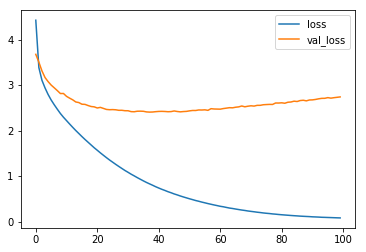

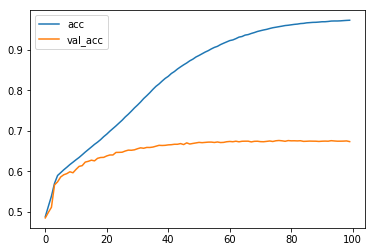

In [38]:
# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
z = np.zeros((NUM_SAMPLES, LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2
)

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()


In [ ]:
model.summary()

In [39]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context,alphas = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

In [40]:
# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c,alphas]
)



# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [41]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
  output_sentence = []
  attention=list()
  for _ in range(max_len_target):
    o, s, c,att = decoder_model.predict([target_seq, enc_out, s, c])

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      attention.append(att)
      word = idx2word_trans[idx]
      output_sentence.append(word)
    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return [' '.join(output_sentence),attention]


In [42]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation,attention = decode_sequence(input_seq)
  print('-')
  print(attention)
  print('Input sentence:', input_texts[i])
  print('Predicted translation:', translation)
  print('Actual translation:', target_texts[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break


-
[array([[[6.6730136e-04],
        [3.6986501e-04],
        [1.7219868e-04],
        [9.4769857e-05],
        [5.7208370e-05],
        [3.9496274e-05],
        [2.7851793e-05],
        [1.1806949e-04],
        [9.8977610e-04],
        [1.0196244e-02],
        [9.8726720e-01]]], dtype=float32), array([[[0.11568973],
        [0.11481178],
        [0.10910194],
        [0.10217658],
        [0.0934867 ],
        [0.08753157],
        [0.08102379],
        [0.07526647],
        [0.07308529],
        [0.07198075],
        [0.07584539]]], dtype=float32), array([[[0.10440028],
        [0.10089081],
        [0.09191166],
        [0.08045451],
        [0.07137188],
        [0.06930311],
        [0.06776162],
        [0.0976239 ],
        [0.10233378],
        [0.10291257],
        [0.11103582]]], dtype=float32), array([[[0.12688115],
        [0.09279593],
        [0.06283483],
        [0.04574872],
        [0.03630753],
        [0.03348854],
        [0.02882419],
        [0.08309868],
        

KeyboardInterrupt: 